# Multi-objective robust decision making (MORDM)


This exercise demostrates the application of MORDM on the lake model, which was used in earlier exercises.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving thecandidate solutions



## Step 1: Problem formulation
### Lake Model

Remember the lake problem used in the assignments in previous weeks. The lake problem is a hypothetical case where the inhabitants of a lake town decide on the amount of annual pollution they release into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication.

The lake problem has 4 **outcome indicators**: 
   - **max_P**: maximum pollution over time, to be minimized
   - **utility**: economic benefits obtained from polluting the lake, to be maximized
   - **inertia**: the percentage of significant annual changes in the anthropogenic pollution rate, to be maximized
   - **reliability**: the percentage of years where the pollution level is below the critical threshold, to be maximized
    
See the lake model exercise for the formulation of these outcome variables.

The lake problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |


The lake problem in previous assignments had 100 decision **levers**, meaning that the decision makers independently decide on the amount of anthropogenic pollution at every time step (100). Then a 'policy' was a set of values for these 100 levers, which you composed by sampling from the range [0, 0.1].   

In this exercise, we will use a more advanced way of deciding on the amout of anhtropogenic polution. We will use a **closed loop** version of the lake model, meaning that $a_t$ (anthropogenic pollution) is dependent on $X_t$ (the pollution level at time t). For instance, the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following [Quinn et al. 2017](http://www.sciencedirect.com/science/article/pii/S1364815216302250) and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert^3, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the pollution strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$).

Note:: i is index for the realization, given m realizations; j is the index for the radial basis function, given 2 radial basis functions. 

**To formulate this problem, do the following:**

**1) Define a function for the anthropogenic pollution given values for $c_1$, $c_2$, $r_1$, $r_2$, $w_1$, and $X_t$**

**2) adapt the lake model function, which is the 'system model' for this problem, from the previous assignments to use this new decision rule.**

*hint*: in this formulation the decision is specified by a decision rule. You specify the decision rule using the radial basis functions. An example of such a rule is shown in figure 2 in Quinn et al (2017). Since you are making the actual release decision in a given year conditional on the observed pollution in the lake in the previous year, your actual release will differ from one stochastic realization to the next. This means that you have to ensure that you adapt the inertia objective accordingly! 

**3) Create an ema_workbench interface for this problem, with corresponding uncertainties, levers and outcomes.**


try to work it out yourself first. If you struggle, have a look [here](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/general-introduction.html)


In [5]:
from ema_workbench import (Model, RealParameter, ScalarOutcome)

from dps_lake_model import lake_model

model = Model('lakeproblem', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

#specify outcomes
# note how we need to explicitely indicate the direction
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional on a reference scenario. These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. For instance, when we optimize the lake model levers, the lake model function will be called for each candidate evaluation, and the corresponding four objective values will be generated. 

*Platypus* is python package developed by David Hadka (http://platypus.readthedocs.io/en/latest/) for multi-objective optimization. It allows an explicit specification of the problem components (levers, objectives, constraints). The package includes several multi-objective evolutionary algorithms, therefore the users can choose the algorithm they wish to use. 

you can use pip to install it:

```
pip install git+https://github.com/Project-Platypus/Platypus.git

```

In this exercise, I recommend to use Platypus with the ε-NSGAII algorithm, since it is shown to outperform many MOEA’s. For other algortihms, see the documentation of Platypus. For a comparison of them, you can have a look at [Reed et al (2013)](http://dx.doi.org/10.1016/j.advwatres.2012.01.005).
    
    
Take the model interface developed in the previous step and use the optimization functionality of the workbench to identify the pareto approximate set of solutions. Try the following:
* change the epsilon values between 0.01 and 0.1, what changes, why?

I explained in class that epsilon controls the the 'gridding' of the outcome space. So, let's first generate results for both 0.01, and 0.01, and than visualize the resulting outcomes. We would expect more solutions, in case of the finer (i.e. lower) gridding


In [2]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

# requires master branch of workbench
# enables us to avoid logging to many intermediate results
# can be ignored without invalidating results
BaseEvaluator.reporting_frequency = 0.1

with MultiprocessingEvaluator(model) as evaluator:
    results1 = evaluator.optimize(nfe=5e3, searchover='levers',
                                 epsilons=[0.1,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 199/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 297/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 397/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 495/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1

In [3]:
with MultiprocessingEvaluator(model) as evaluator:
    results2 = evaluator.optimize(nfe=5e3, searchover='levers',
                                 epsilons=[0.01,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 199/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 299/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 398/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 498/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 

/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


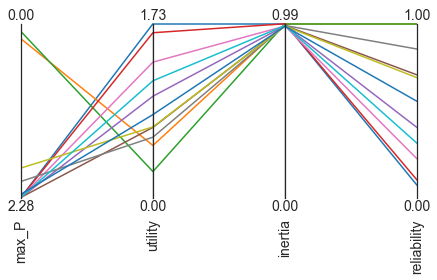

In [4]:
from ema_workbench.analysis import parcoords

data = results1.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()

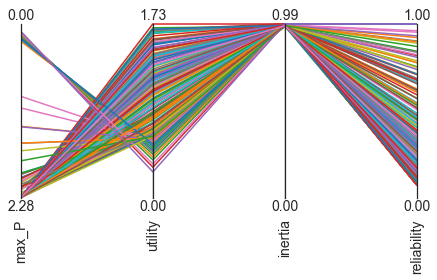

In [5]:
data = results2.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()

The above parallel coordinate plots are consistent with our expectation. If we use a lower value for epsilon, we have many more solutions in the pareto approximate set.

* change the number of function evaluations from 1000 to 10.000 (this requires using multiprocessing unless you are very patient). What is the difference? You can use  convergence as explained in the [workbench documentation](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/directed-search.html


Calculating hypervolume can be tricky. It requires specifying the minimum and maximum values that can occur. That is, we basically have to describe the hyperbox within which hypervolume needs to be calculated. There are various ways we can ensure this. For example we take the values quite broad to be certain. We can also add constraints to the outcome space. We can rely on trial and error. Below, I am using the results from the previous optimization to provide guestimated values for the maximum.  

Calculating hypervolume is computationally expensive. Therefore, it might sometimes be better to simply log the state of the achive at each generation, and only calculate hypervolume afterwards. See the [ArchiveLogger](http://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/optimization.html#ema_workbench.em_framework.optimization.ArchiveLogger) which you can use just like other convergence metrics for details


In [6]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[3, 2,1.01,1.01]),
                       EpsilonProgress()]

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=1e3, searchover='levers',
                                 convergence=convergence_metrics,
                                 epsilons=[0.1,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 199/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 397/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 496/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 m

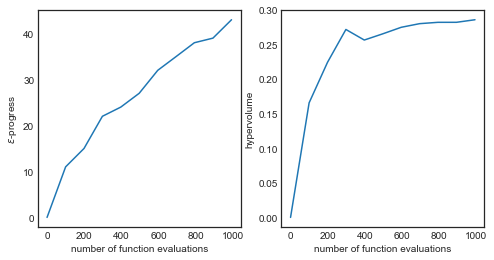

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [8]:
convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[3, 2,1.01,1.01]),
                       EpsilonProgress()]

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=1e4, searchover='levers',
                                 convergence=convergence_metrics,
                                 epsilons=[0.1,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 198/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 297/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 395/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 492/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies

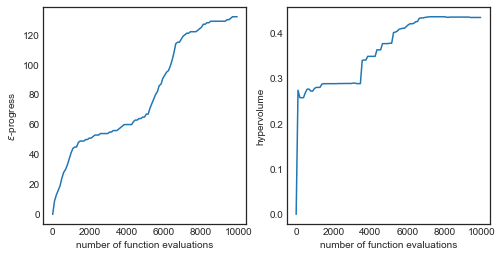

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

As you can see, the optimization has converged better in the second case with the higher number of function evaluations. Note also how in this particular case, search stagnated between 1000 and 4000 nfe, before picking up agin. Still, to be certain, it would be good practice to use an even larger number of nfe (I would start wtih at least 50,000, preferably even larger). 

**plot the tradeoffs you have found using a parallel axis plot**

We can visualize these tradeoffs on a **parallel axis plots**. In these plots, each dimension is shown as a vertical axis. Each solution is represented by a line on this plot, which crosses the objective axes at the corresponsing value. You can use the [parcoords functionality](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html) for this that comes with the ema_workbench. Ensure that the direction of desirability is the same for the four objectives.|



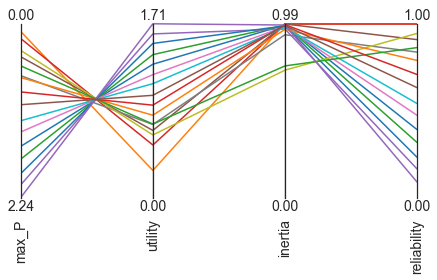

In [10]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

Max_P is negatively correlated with utility and intertia, and positevely with reliability. if we look at inertia, there are two solutions which sacrifice intertia for higher scores on reliability. These might reflect a different correlation structure, or be evidence of incomplete convergence. 


## Step 3: Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_reults**

**From new_results, which is the reduced dataframe of candidate solutions, make a list of policies in a format that can be inputed to the *perform_experiments* function of the EMA workbench.**

*hint: you need to transform each policy to a dict, and then use this dict as input for the Policy class that comes with the workbench*

There are various ways to do it. One way is to use logical indexing. Basically, create a boolean vector that indicates for each row if the constraint is met or not. Next, we can use this as an index on the dataframe to get only the rows for which the index is true.




In [12]:
logical = results.reliability > 0.9
np.sum(logical)

4

In [13]:
results[logical]

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
1,0.202695,0.394344,0.363693,1.460510,0.261996,0.099891,0.266632,0.9900,1.0000
3,0.333252,0.141959,0.289677,1.407666,0.208483,0.190748,0.516531,0.9900,1.0000
5,0.237332,0.586084,0.054338,1.304695,0.232653,0.425794,0.659801,0.9887,0.9088
8,0.237999,0.586084,0.054338,1.792260,0.271395,0.344055,0.615650,0.7258,0.9446


In [17]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,c1,c2,r1,r2,w1
1,0.202695,0.394344,0.363693,1.460510,0.261996
3,0.333252,0.141959,0.289677,1.407666,0.208483
5,0.237332,0.586084,0.054338,1.304695,0.232653
8,0.237999,0.586084,0.054338,1.792260,0.271395


In [25]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

**Perform 1000 scenarios for each of the policy options. Depending on how many solutions are left after implementing the constraint, consider using multiprocessing or ipyparallel to speed up calculations.**

If you want to use ipyparallel, don't forget to start ipcluster.

In [26]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


write the new_results to a csv file. You will need them to complete the MORO assignment.

I choose to save all the results. You could instead also save just the filtered policies using the to_csv method


In [28]:
from ema_workbench import save_results

save_results(results, 'MORDM_reevaluation.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/jhkwakkel/Documents/workspace/epa1361/Week 6-7 - robustness and direct search/MORDM_reevaluation.tar.gz


In [29]:
policies.to_csv('mordm filtered polices.csv')

We can now evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow range of uncertainty about the outcomes. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation should be different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [2]:
from ema_workbench import load_results

results = load_results('MORDM_reevaluation.tar.gz')


In [3]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
    

There are various ways in which we could calculate the signal to noise ratio. Here, I choose to iterate over the policy first. Next, I iterate over the outcomes. For each outcome, I only retrieve the results associated with the current policy. Next, I can calculate the signal to noise ratio. 

I am reusing the direction that we already specified for each outcome of interest, to avoid duplicating code. Note that I enabled this already with how I defined the s_to_n function above.

To make visualization easy, I transform all my results into a dataframe at the end.

In [6]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,inertia,max_P,reliability,utility
1,120.151933,8.027876,1.884786,0.966933
3,123.679227,8.050322,1.784728,1.365021
5,4.566264,10.433776,1.264932,1.608799
8,4.754055,10.240316,1.299198,1.558718


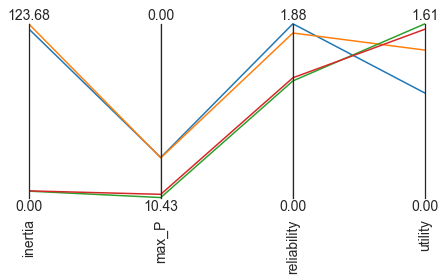

In [8]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()


The ideal solution would be a a high Signal to Noise score for reliability, inertia, and utility, and a low score for max_P. Such a solution clearly does not exist. The best solution for max_P and reliability score low on inertia and utility. No compromise solution can thus be found in this case. 


Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

**Write a function to calculate the maximum regret for both kinds of outcome indicators. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [9]:
def calculate_regret(data, best):
    return np.abs(best-data)

Regret is the performance difference between the best possible outcome in a scenario across policies, the the observed outcome for a given policy. We have in this case both minimization and maximization. Best means the lowest in case of mimimization, and heighest in case of maximization. To avoid having to explicitly account for this in how we calculate the difference, we can simply take the absolute value of the difference. In this case, max_P will return negative regret values for `best-data`, so by taking the absolute value, we fix this

The next part of the code is probably the most tricky part. We need to find the best possible outcome for each scenario. We could do this by iterating over the scenario_id column in the experiment array. But we can also use pandas instead as done below. Wat we do is the following:
1. we create a dataframe with the outcome, the name of the policy and the scenario id. This is a so called long-form representation of the data
2. We want to have the results for each policy side by side so we can take the max, or min accross the column. The pivot method on the DataFrame does this for us
3. We take the maximum or minimum accross the row.

In [46]:
experiments, outcomes = results

regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario_id":experiments['scenario_id']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario_id', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    regret[outcome.name] = regret
    max_regret[outcome.name] = outcome_regret.max()
    

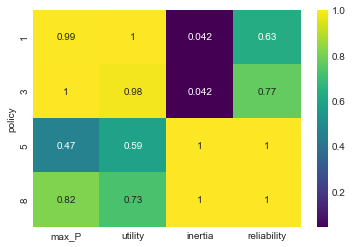

In [52]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

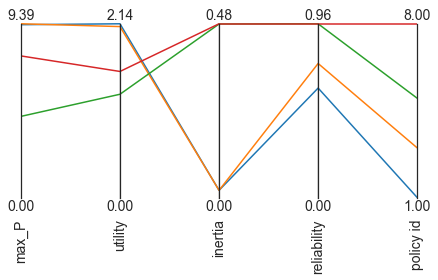

In [53]:
data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
data['policy id'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)

plt.show()

We see striking differences between blue and orange (1 and 3) and green and red (5 and 8). The first two options have low regret on the first three objectives, but higher regret on utility. For the second two options it is reversed

Note that we have been looking at the maximum regret. I also saved the distribution of regret over the set of scenarios. So let's visualize this and see what we can learn from it


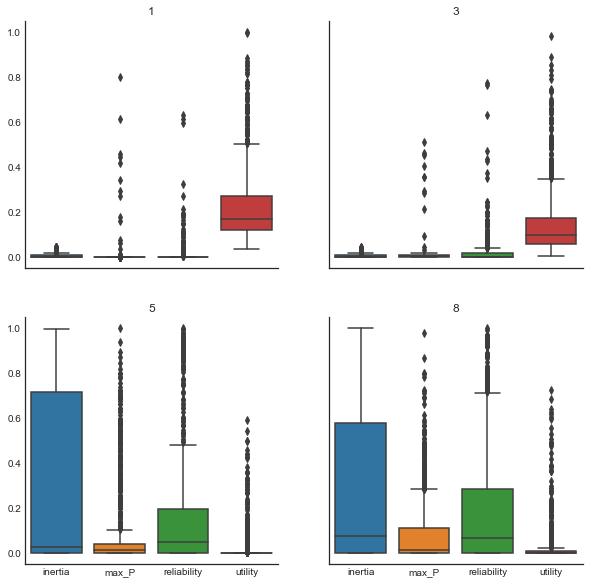

In [197]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, overall_regret.items()):
    data = pd.DataFrame(regret)
    
    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    data = data.drop("policy id", axis=1)
    
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(policy)
plt.show()

This is in line with the maximum regret parallel coordinates plot, but we get some more details. 1 is higher than 3 on utility regret, but 3 has some reliability regret. 5 has more high inertia regret cases than 8, but is lower on max_P and reliability.